In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

from IPython.display import clear_output
import time
from datetime import datetime
import itertools

sns.set_style('darkgrid')

#### Machine Learning: Classificação

In [3]:
from sklearn.preprocessing import LabelEncoder as le, StandardScaler as ss, MinMaxScaler as mms
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit as sss, train_test_split
from sklearn.metrics import accuracy_score as acc_scr, r2_score, classification_report, confusion_matrix, make_scorer

scorer = make_scorer(acc_scr)

from sklearn.metrics import accuracy_score as acc_scr
from sklearn.metrics import matthews_corrcoef 
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, precision_recall_fscore_support

from sklearn.preprocessing import LabelBinarizer

# DEFININDO FUNÇÕES

#### Rotulação de Variáveis

In [4]:
def encode(df_copy, test_set=None, ordinal_cols=None, label_cols=None, float_cols=None, string_cols=None, int_cols=None, onehot_cols=None, concat_onehot=False, prefix_col=''):
    
    if type(test_set)==type(None): dfs = [df_copy.copy()]
    else: dfs = [df_copy.copy(), test_set.copy()]
    
    new_dfs = []
    for df in dfs.copy():

        if type(ordinal_cols)!=type(None):
            n_ordinals = len(ordinal_cols)
            for i, col in enumerate(ordinal_cols):
                ord_encoded_col = df[col].to_frame()
                df[col] = oe().fit(ord_encoded_col).transform(ord_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Ordinais... - ', i, '/', n_ordinals)

        if type(label_cols)!=type(None):
            n_labels = len(label_cols)
            for i, col in enumerate(label_cols):

                label_encoded_col = df[col]
                df[col] = le().fit(label_encoded_col).transform(label_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Categóricas... - ', i, '/', n_labels)

        if type(float_cols)!=type(None):
            n_floats = len(float_cols)
            for i, col in enumerate(float_cols):

                df[col] = df[col].astype(float)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "Float"... - ', i, '/', n_floats)

        if type(string_cols)!=type(None):         
            n_strings = len(string_cols)
            for i, col in enumerate(string_cols):

                df[col] = df[col].astype(str)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_strings)

        if type(int_cols)!=type(None):         
            n_int = len(int_cols)
            for i, col in enumerate(int_cols):

                df[col] = df[col].astype(int)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_int)

        if type(onehot_cols)!=type(None):         
            n_onehot = len(onehot_cols)
            onehot_lst = []
            for i, col in enumerate(onehot_cols):
                onehot_lst.append(pd.get_dummies(df[col], prefix=col+prefix_col))
                clear_output(wait=True)
                print('OneHot Encoding Variáveis... - ', i, '/', n_onehot)

            print('Concatenando Variáveis Onehot...')
            onehot_df = pd.concat(onehot_lst, axis=1)

            if concat_onehot: 
                print('Concatenando Dataframe OneHot...')
                df = pd.concat([df, onehot_df])
            else: 
                df = pd.concat([df.drop(onehot_cols, axis=1), onehot_df], axis=1)

        new_dfs.append(df.copy())
    
    if type(onehot_cols)!=type(None):
        if type(test_set)!=type(None):          
            keep_cols = list(set(new_dfs[0].columns).intersection(new_dfs[1].columns))
            new_dfs = [new_df[keep_cols] for new_df in new_dfs]
            
    return new_dfs

#### Filtragem de Categorias

In [5]:
def filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False):
    
    print('Construindo Index...')       # Selecionando index onde alvo em 'ctgr_lst'
    new_index=[]
    for ctgr in ctgr_lst:
        new_index += df[df[target]==ctgr].index.tolist()
    
    print('Extraindo Dados da Tabela...')      # Extraindo tabela com index construído
    df = df.loc[new_index]    
    
    if type(replace_dict)!=type(None):
        print('Substituindo Categorias: {}'.format(replace_dict))      # Fusão de categorias
        for key in replace_dict.keys():
            df[target] = df[target].replace(key, replace_dict[key])
    
    if encode:
        print('Rotulando Variável Alvo...')
        df[target] = le().fit(df[target]).transform(df[target])      # Rotulando variável alvo
        
    print('\nCategorias Atualizadas!')
    return df

#### Avaliação de Modelos

In [6]:
def score_betas(y_test, y_pred, betas):
    
    fbeta_scrs=[]
    for beta in betas:
        fbeta_scrs.append(fbeta_score(y_test, y_pred, beta=beta))

    return pd.Series(fbeta_scrs, index=betas)

def scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False):
    
    n_models=len(models)
    if type(params_list)==type(None): params_list = [{}]*n_models

    rows = []
    cnt=1
    for model, name, params in zip(models, names, params_list):

        if clear: clear_output(wait=True)
        print('\nAvaliando Modelo {} - ({}/{})'.format(name, cnt, n_models))
        
        if triple:
                
            row = scr_triple(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        else:
        
            row = scr(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        
        rows.append(row)
        cnt+=1

    scrs_df = pd.concat(rows, axis=1).T
    if keep_params: 
        params_df = pd.DataFrame(params)
        scrs_df = pd.concat([scrs_df, params_df], axis=1)
        
    return scrs_df

def scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1):

    if verbose>=2: print('\nExtraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        if verbose >= 1: print('\nConstruindo Modelo {}...'.format(name))
        new_model = model(**params)
        if verbose >= 1: print('Fitting...')
        new_model.fit(x_train, y_train)
        if verbose >= 1: print('Predicting...')
        y_pred = new_model.predict(x_test)
        if verbose >= 1: print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

def scr_triple(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10))):

    print('Extraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - 2',
             'recall - 2',
             'f1-score - 2',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        print('Construindo Modelo {}...'.format(name))
        new_model = model(**params)
        print('Fitting...')
        new_model.fit(x_train, y_train)
        print('Predicting...')
        y_pred = new_model.predict(x_test)
        print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['2'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

#### Eliminação Recursiva de Variáveis

In [202]:
def scr_fitted(fitted_model, test_set, target, features=None, method='classes'):
    
    if type(features) == type(None): features = list(set(test_set.columns)-set([target]))
    y_test, x_test = test_set[target], test_set[features]
    y_pred = fitted_model.predict(x_test)
    
    if method=='classes':
        scr = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    return scr

def RFE_rank(train_set, target, estimator, est_params={}, k=10, step=1, verbose=1):

    features = list(set(train_set.columns).difference([target]))
    x, y = train_set[features], train_set[target]

    rfe = RFE(estimator(**est_params), k, step, verbose)
    rfe.fit(x, y)

    sel_estimator = rfe.estimator_
    sel_features = np.array(features)[rfe.support_]
    rank = pd.Series(rfe.ranking_, index=features)
    
    return sel_estimator, sel_features, rank

def RFE_ranks(estimators, names, est_params_list, train_set, target, k=1, step=1, verbose=1, save=False, path=None):
    
    estimators_ranks = []
    cnt=1
    n_estimators=len(estimators)
    for estimator, name, est_params in zip(estimators, names, est_params_list):
        
        clear_output(wait=True)
        print('Eliminação de Variável Recursiva: {} - ({}/{})'.format(name, cnt, n_estimators))
        
        sel_estimator, sel_features, rank = RFE_rank(train_set, target, estimator=estimator, est_params=est_params, k=k, step=step, verbose=verbose)    
        if save:
            rank.to_frame().to_csv(path.format(name))
            
        estimators_ranks.append(rank)
        cnt+=1

    ranks_df = pd.concat(estimators_ranks, axis=1)
    ranks_df.columns=names
    
    return ranks_df

In [240]:
def recursive_scoring(train_set, test_set, target, rank, models, names, params_list, rank_degree=1, rank_name='', n_first=None):
    
    features = rank.index
    rank_scrs = []
    rank_lst = sorted(rank.unique())    
    rank_max = max(rank_lst) # To stop loop
    stop=0
    for rank_i in rank_lst:
        
        #rank_trans = int(((rank_i/rank_max)**rank_degree)*rank_max)
        
        if type(n_first)!=type(None):
            if rank_i>n_first:
                
                rank_i = n_first + (rank_i-n_first)**rank_degree
                rank_i = int(rank_i)
        
        else:
            rank_i = int(rank_i**rank_degree)
        
        if rank_i>=rank_max:
            stop+=1
            rank_i = rank_max
            if stop==2: break
        
        clear_output(wait=True)
        print('Treinamento{} com colunas até o rank {}/{}'.format(' '+rank_name, rank_i, rank_lst[-1]))

        features_i = list(features[rank<=rank_i]) + [target]
        print('Número de Colunas: {}'.format(len(features_i)))

        scr_i = scr_models(train_set[features_i], test_set[features_i], target, models, names, params_list, clear=False)
        scr_i['rank'] = rank_i
        rank_scrs.append(scr_i)
    
    rank_df = pd.concat(rank_scrs, axis=0)
    
    return rank_df
        


def ranks_recursive_scoring(ranks_df, train_set, test_set, target,
                            models, names, params_list,
                            rank_degree=1, path=None, n_first=None):
    
    ranks_scrs = []
    models_ranks = ranks_df.columns
    n_ranks = len(models_ranks)
    cnt=1
    
    for name in models_ranks:
        rank = ranks_df[name]
        rank_scr = recursive_scoring(train_set, test_set, target, rank,
                                     models, names, params_list,
                                     rank_degree=rank_degree, rank_name=name, n_first=n_first)
        rank_scr['rank model'] = name
        
        if type(path)!=type(None): 
            rank_scr.to_csv(path.format(name))
        ranks_scrs.append(rank_scr)
        cnt+=1
                
    rec_ranks_df = pd.concat(ranks_scrs, axis=0)
    return rec_ranks_df
    

In [295]:
def recursive_scoring_reg(train_set, test_set, target, rank, models, params_list, rank_degree=1, rank_name='', n_first=None):
    
    rank_features = rank.index
    rank_scrs = []
    rank_lst = sorted(rank.unique())    
    rank_max = max(rank_lst) # To stop loop
    stop=0
    for rank_i in rank_lst:
        
        #rank_trans = int(((rank_i/rank_max)**rank_degree)*rank_max)
        
        if type(n_first)!=type(None):
            if rank_i>n_first:
                
                rank_i = n_first + (rank_i-n_first)**rank_degree
                rank_i = int(rank_i)
        
        else:
            rank_i = int(rank_i**rank_degree)
        
        if rank_i>=rank_max:
            stop+=1
            rank_i = rank_max
            if stop==2: break
        
        clear_output(wait=True)
        print('Treinamento{} com colunas até o rank {}/{}'.format(' '+rank_name, rank_i, rank_lst[-1]))

        features_i = list(rank_features[rank<=rank_i]) + [target]
        print('Número de Colunas: {}'.format(len(features_i)))

        scr_i = scr_regs(train_set[features_i], test_set[features_i], target, models, params_list, clear=False)
        scr_i['rank'] = rank_i
        rank_scrs.append(scr_i)
    
    rank_df = pd.concat(rank_scrs, axis=1)
    rank_df.columns = rank_df.loc['rank']
    rank_df.drop('rank', 0, inplace=True)
    
    return rank_df
        


def ranks_recursive_scoring_reg(ranks_df, train_set, test_set, target,
                            models, params_list,
                            rank_degree=1, path=None, n_first=None):
    
    ranks_scrs = []
    models_ranks = ranks_df.columns
    n_ranks = len(models_ranks)
    cnt=1
    
    for name in models_ranks:
        rank = ranks_df[name]
        rank_scr = recursive_scoring_reg(train_set, test_set, target, rank,
                                     models, params_list,
                                     rank_degree=rank_degree, rank_name=name, n_first=n_first)
        
        rank_scr['rank model'] = name
        ranks_scrs.append(rank_scr)
        cnt+=1
        
        if type(path)!=type(None): 
            rank_scr.to_csv(path.format(name))
                
    rec_ranks_df = pd.concat(ranks_scrs, axis=0)
    return rec_ranks_df
    

# Feature Elimination

In [330]:
rec_scrs = ranks_recursive_scoring_reg(ranks_df.iloc[:, [1,2]], small_train_set, test_set, target_lp, good_models, params_list=None, rank_degree=2,  n_first=3)

Treinamento BayesianRidge com colunas até o rank 26/26
Número de Colunas: 520
Scoring HistGradientBoostingRegressor - (1/10)

Fitting...
Predicting...
Scoring...
Scoring GradientBoostingRegressor - (2/10)

Fitting...
Predicting...
Scoring...
Scoring ExtraTreesRegressor - (3/10)

Fitting...
Predicting...
Scoring...
Scoring RandomForestRegressor - (4/10)

Fitting...
Predicting...
Scoring...
Scoring BaggingRegressor - (5/10)

Fitting...
Predicting...
Scoring...
Scoring LassoLarsCV - (6/10)

Fitting...
Predicting...
Scoring...
Scoring LarsCV - (7/10)

Fitting...
Predicting...
Scoring...
Scoring OrthogonalMatchingPursuit - (8/10)

Fitting...
Predicting...
Scoring...
Scoring LassoLarsIC - (9/10)

Fitting...
Predicting...
Scoring...
Scoring OrthogonalMatchingPursuitCV - (10/10)

Fitting...
Predicting...
Scoring...


In [331]:
rec_scrs

rank,1.0,2.0,3.0,4.0,7.0,12.0,19.0,26.0,rank model
HistGradientBoostingRegressor,0.605315,0.607469,0.607377,0.608536,0.612395,0.609049,0.603513,0.619801,AdaBoostRegressor
GradientBoostingRegressor,0.621586,0.622420,0.618716,0.618946,0.622678,0.617787,0.620792,0.623435,AdaBoostRegressor
ExtraTreesRegressor,0.623311,0.627060,0.623350,0.623433,0.624955,0.619265,0.622012,0.622198,AdaBoostRegressor
RandomForestRegressor,0.608756,0.609627,0.609200,0.611498,0.606236,0.610555,0.607523,0.613908,AdaBoostRegressor
BaggingRegressor,0.572041,0.564171,0.579784,0.575431,0.581773,0.571089,0.547889,0.565251,AdaBoostRegressor
LassoLarsCV,0.529814,0.530164,0.528422,0.527398,0.526697,0.524588,0.526228,0.530770,AdaBoostRegressor
LarsCV,0.529814,0.529017,0.528422,0.527454,0.525908,0.524884,0.525468,0.530453,AdaBoostRegressor
OrthogonalMatchingPursuit,0.482780,0.508189,0.518562,0.519037,0.533165,0.522075,0.516322,0.506174,AdaBoostRegressor
LassoLarsIC,0.524821,0.523911,0.525870,0.525092,0.525011,0.521496,0.522912,0.521511,AdaBoostRegressor
OrthogonalMatchingPursuitCV,0.519124,0.519124,0.518562,0.519037,0.519037,0.518562,0.518562,0.518562,AdaBoostRegressor


In [349]:
rec_scrs = rec_ranks_df

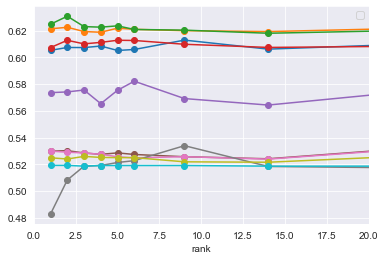

In [350]:
rec_scrs[rec_scrs['rank model']==rec_scrs['rank model'].unique()[1]].T.drop('rank model').plot(xlim=(0,20), marker='o')
plt.legend([])

In [308]:
small_train_set = train_set.loc[np.random.choice(train_set.index, 2000, replace=False)]

In [308]:
small_test_set = test_set.loc[np.random.choice(test_set.index, 1000, replace=False)]

In [308]:
features = [col for col in train_set.columns if col!=target_lp]

In [309]:
gbr = models['GradientBoostingRegressor']().fit(small_train_set[features], small_train_set[target_lp])

In [343]:
abc = models['AdaBoostRegressor']().fit(small_train_set[features], small_train_set[target_lp])

In [310]:
y_pred = gbr.predict(test_set[features])

In [316]:
r2_score(test_set[target_lp], y_pred)

0.6232178292922559

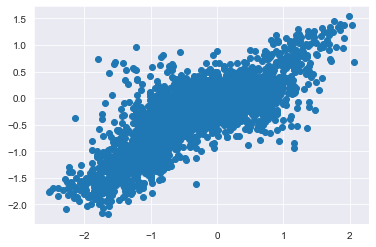

In [313]:
plt.scatter(test_set[target_lp], y_pred)

Tamanho da Amostra de Teste: 2600
r2_score: 0.628713698175954


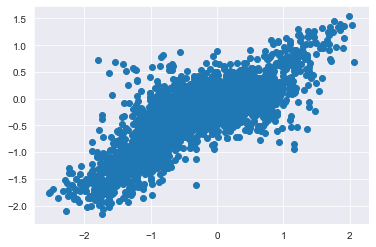

In [347]:
for test_size in range(100,3000,500):

    small_test_set = test_set.loc[np.random.choice(test_set.index, test_size, replace=False)]
    y_pred = gbr.predict(small_test_set[features])
    
    clear_output(wait=True)
    print('Tamanho da Amostra de Teste: {}'.format(test_size))
    print('r2_score:', r2_score(small_test_set[target_lp], y_pred))
    plt.scatter(small_test_set[target_lp], y_pred)
    plt.show()
    plt.pause(1)
    

Tamanho da Amostra de Teste: 2600
r2_score: 0.6247138468187361


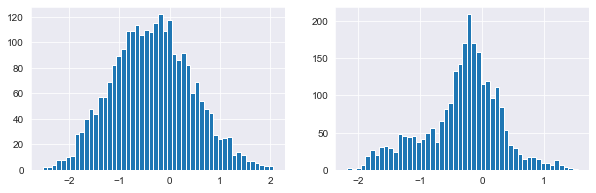

In [407]:
for test_size in range(100,3000,500):

    small_test_set = test_set.loc[np.random.choice(test_set.index, test_size, replace=False)]
    y_pred = gbr.predict(small_test_set[features])
    
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    
    clear_output(wait=True)
    print('Tamanho da Amostra de Teste: {}'.format(test_size))
    print('r2_score:', r2_score(small_test_set[target_lp], y_pred))
    axs[0].hist(small_test_set[target_lp], bins=50)
    axs[1].hist(y_pred, bins=50)
    plt.show()
    plt.pause(1)
    

### Selecionando Modelos para Análise

In [ ]:
def intersection(lists):
    a=set(lists[0])
    for i in range(1,len(lists)):
        a = a.intersection(lists[i])
    return a

def n_top_intersection_analysis(top_lists):
    
    n_lists = len(top_lists)
    n_top_max = len(top_lists[0])    
    len_inter = []
    for i in range(1, n_top_max+1):
        
        top_lists_n = [top_lists[j][:i] for j in range(n_lists)]
        
        inter = len(intersection(top_lists_n))
        ttl=len(np.unique(np.array(top_lists_n)))
        len_inter.append([i, inter, inter/i, ttl, inter/ttl, ttl/i])

    len_inter_df = pd.DataFrame(len_inter, columns=['n top colunas mais importantes', 'interseção', 'interseção por n top',
                                                    'colunas unicas', 'interseção por colunas unicas', 'colunas unicas por n top'])
    return len_inter_df

def n_members_intersection_analysis(top_lists_org, n_members=2, rank_degree=2, rank_step=1):
       
    n_lists_org = len(top_lists_org)
    n_top_max = len(top_lists_org[0])    
    
    groups = list(itertools.combinations(range(n_lists_org), n_members))
    n_groups = len(groups)
    groups_stats = []
    cnt_grp = 0
    
    for group in groups:
              
        
        top_lists = [top_lists_org[member] for member in group]
        n_lists = len(top_lists)

        
        loop = np.array(range(rank_step, n_top_max+1, rank_step))**rank_degree
        stop=0
        for i in loop:
    
            if i>=n_top_max+1:
                stop+=1
                i = n_top_max+1
                if stop==2: break

            clear_output(wait=True)
            print('Grupo {}/{} - {}/{}'.format(cnt_grp, n_groups, i, n_top_max))
                 
            top_lists_n = [top_lists[j][:i] for j in range(n_lists)]

            inter = len(intersection(top_lists_n))
            unique = len(np.unique(np.array(top_lists_n)))

            groups_stats.append([group, n_members, i, inter, inter/i, unique, inter/unique, unique/i])
        
        cnt_grp+=1

    groups_df = pd.DataFrame(groups_stats, columns=['group', 'n_members', 'n top colunas mais importantes', 'interseção', 'interseção por n top',
                                                        'colunas unicas', 'interseção por colunas unicas', 'colunas unicas por n top'])
    
    return groups_df

def n_top_combinations_intersection_analyses(top_lists_org, min_members=2, max_members=3, member_step=1, rank_degree=2, rank_step=1):
    
    n_members_lst = []
    for n_members in range(min_members, max_members+1, member_step):
        
        n_stats = n_members_intersection_analysis(top_lists_org, n_members=n_members, rank_degree=rank_degree, rank_step=rank_step)
        n_members_lst.append(n_stats)
    
    n_members_df = pd.concat(n_members_lst, axis=0)
    
    return n_members_df

def groups_inter(n_members_df0, n_members=2, x_col='n top colunas mais importantes', xlim=None, ylim=None):
    
    n_members_df = n_members_df0[n_members_df0['n_members']==n_members]
    groups = n_members_df['group'].unique()
    n_grps=len(groups)
    
    fig = plt.figure(figsize=(14,9))
    axs = [fig.add_subplot(3,2,i) for i in range(1,6)]
    for i, col in enumerate(n_members_df.columns[3:]):

        
        cnt_grp=1
        
        for group in groups:
            
            clear_output(wait=True)
            print('Desenhando Variável {}/{} - Grupo {}/{}'.format(i+1, 5, cnt_grp, n_grps))
            n_members_df[n_members_df['group']==group].plot(x_col, col, ax=axs[i])
            cnt_grp+=1
            
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

def members_inter(n_members_df, x_col='n top colunas mais importantes', xlim=None, ylim=None, marker=None):
    
    fig = plt.figure(figsize=(14,9))

    axs = [fig.add_subplot(3,2,i) for i in range(1,6)]

    for i, col in enumerate(n_members_df.columns[3:]):

        clear_output(wait=True)
        
        for member in range(2, n_members_df['n_members'].max()+1):
            
            #n_members_df.groupby(['n_members', x_col]).mean().reset_index()
            n_members_df[n_members_df['n_members']==member].groupby([x_col]).mean().reset_index().plot(x_col, col, ax=axs[i], marker=marker)
        
        axs[i].legend([])
        axs[i].set(xlim=xlim, ylim=ylim, title=col)
        axs[i].grid()
        
    plt.show()
    plt.pause(0.1)

In [280]:
def scrs_prog_pages(rec_ranks_df, names, cols, key_0='rank model', key_1='rank'):

    
    for name in names:
        print('Precição {} por rank mmaximo de importancia das colunas:\n'.format(name))
        scrs_prog(rec_ranks_df.loc[name].reset_index().set_index(key_0), cols=cols, key=key_1, full=True)
        if input()=='exit': break
        clear_output(wait=True)


def scrs_prog_pages2(rec_ranks_df, names, cols, key_0='rank model', key_1='rank'):

    
    for name in names:
        print('Precição {} por rank gerado por cada modelo:'.format(name))
        scrs_prog(rec_ranks_df.reset_index().set_index('rank model').loc[name].reset_index().sort_values(key_1).set_index(key_0), cols=cols, key=key_1, full=True)
        if input()=='exit': break
        clear_output(wait=True)


#### Avalição Modelagem de àlvo Contínuo

In [159]:
def scr_reg(train_set, test_set, target, model, params={}):
    
    features = [col for col in train_set.columns if col!=target]
    y, x = train_set[target], train_set[features]
    print('\nFitting...')
    fitted = model(**params).fit(x,y)
    print('Predicting...')
    y_pred = fitted.predict(test_set[features])
    print('Scoring...')
    r2 = r2_score(test_set[target], y_pred)
    
    return r2

def scr_regs(train_set, test_set, target, models, params_list=None, stop=None, clear=True):
    n_models = len(models)
    if type(params_list)==type(None): params_list = [{}]*n_models
    scrs = []
    cnt=1
    for (name, model), params in zip(models.items(), params_list):
        
        if clear: clear_output(wait=True)
        print('Scoring {} - ({}/{})'.format(name, cnt, n_models))
        scr = scr_reg(train_set, test_set, target, model, params)        
        scrs.append(scr)
        cnt+=1
        if stop==cnt-1: break
        

    scrs_ser = pd.Series(scrs, index=list(models.keys())[:(stop if type(stop)!=type(None) else n_models)])
    return scrs_ser

In [ ]:
sklearn.metrics?

#### Calcular importância das variáveis

In [8]:
def feat_imp(df, target, test_size=0.2, random_state=None, n_models=1):

    feat_imp_models = [TREE, RFC, ETC, GBC, ABC][:n_models]
    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC'][:n_models]
    
    y = df[target].copy()
    x = df.drop([target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-test_size), random_state=random_state)

    feat_cols = x_train.columns.tolist()
    scrs = []
    lst = []
    for i in range(len(feat_imp_models)):

        print('({}/{}) {}'.format(i, len(feat_imp_names), feat_imp_names[i]))
        print('Fitting...')
        model = feat_imp_models[i]().fit(x_train, y_train)
        print('Predicting...')
        y_pred = model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)

        feat_imps = model.feature_importances_.tolist()
        lst.append([feat_imp_names[i]]+feat_imps)
        scrs.append([feat_imp_names[i], acc])

        clear_output(wait=True)

    scrs_df = pd.DataFrame(scrs, columns=['model_name', 'acc']).set_index('model_name')
    feat_df = pd.DataFrame(lst, columns=['model_name'] + feat_cols).set_index('model_name')

    return scrs_df, feat_df

#### Gráficos 3D

In [9]:
def plot_3d(xi, yi, zi, angle1=15, angle2=60, method='surface', zdir='z', cmap='coolwarm', norm=False, figsize=(7,4), labels=['X', 'Y', 'Z'], color='blue', alpha=1):
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm=None
    
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]

    if method=='surface': axs[0].plot_surface(yi, xi, zi, cmap=cmap, norm=norm, color=color, alpha=alpha)
    if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, cmap=cmap, color=color, alpha=alpha)
    if method=='contour':  axs[0].contour(xi, yi, zi, stride=1, zdir=zdir, color=color, alpha=alpha)

    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=labels[0], ylabel=labels[1], zlabel=labels[2]) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def plot_3d_ontop(xyz_list, colors_list=None, alpha_list=None, method='surface', zdir='z', angle1=15, angle2=60, cmap=None, norm=False, figsize=(7,4)):
    
    if type(colors_list)==type(None): colors_list=[None]*len(xyz_list)
    if type(alpha_list)==type(None): alpha_list=[1]*len(xyz_list)
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm = None
    
    fig = plt.figure(figsize=figsize)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]
    
    for i, (xi, yi, zi) in enumerate(xyz_list):

        if method=='surface': axs[0].plot_surface(yi, xi, zi, color=colors_list[i], alpha=alpha_list[i], cmap=cmap, norm=norm)
        if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)
        if method=='contour':  axs[0].contour(xi, yi, zi, alpha=1, stride=1, zdir=zdir)

            
    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=xs.name, ylabel=ys.name, zlabel=zs.name) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def rotate_3d(xyz, on_top=False, steps=(10,10), starts=(0,0), stops=(360,360), method='surface', zdir='z', colors_list=None, alpha_list=None, cmap=None, norm=False, figsize=(7,4), angle_var=7, labels=['X', 'Y', 'Z']):
    
    if not on_top: xi, yi, zi = xyz
    
    for angle1, angle2 in zip(range(starts[0], stops[1], steps[0]), range(starts[0], stops[0], steps[1])):
        
        if on_top: plot_3d_ontop(xyz, method=method, zdir=zdir, angle1=angle1/angle_var, angle2=angle2, colors_list=colors_list, alpha_list=alpha_list, cmap=cmap, norm=norm, figsize=figsize)
        
        else: plot_3d(xi, yi, zi, angle1=angle1/angle_var, angle2=angle2, method=method, zdir=zdir, figsize=figsize, labels=labels)


def full_plot_3d(xi, yi, zi, cmap='coolwarm', method='surface'):

    for angle, angle2 in zip(range(0,360,10), range(0, 360, int(10))):

        fig = plt.figure(figsize=(13,7))
        axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


        if method=='surface': axs[0].plot_surface(yi, xi, zi, alpha=1, cmap=cmap)

        else: axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)

        axs[1].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='x',
                       offset=None)
        axs[2].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='y',
                       offset=None)
        axs[3].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='z',
                       offset=None)

        [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
        [axs[k].set(xlabel='X', ylabel='Y', zlabel='Z') for k in range(4)]

        clear_output(wait=True)
        plt.show()
        plt.pause(0.001)
    #    if input()=='exit': break

In [10]:
def list_sets(train_set, test_set, target, keep_list):
    sets = []
    for keep in keep_list:
        cols = keep + [target]
        sets.append([train_set[cols], test_set[cols]])
    
    print('Sets Shapes::')
    [print(set_i[0].shape, set_i[1].shape) for set_i in sets]
    
    return sets

def score_sets(sets, sets_names, target, models, names, params_list=None, method='classes', save=False, path=None, index=True):
    scrs = []
    cnt=0
    for (train, test), set_name in zip(sets, sets_names):

        clear_output(wait=True)
        print('Scoring Set: ', cnt+1, '/ {}'.format(len(sets)))

        new_scr = scr_models(train, test, target, models, names, params_list, method=method, clear=False)
        new_scr['set']=set_name
        
        if save:
            new_scr.to_csv(path+set_name+'.csv', index=index)
        
        scrs.append(new_scr)
        cnt+=1
        
    scrs_df = pd.concat(scrs, axis=0)
    #scrs_df['Set']=[set_name for j in range(len(models)) for set_name in sets_names]
    
    clear_output(wait=False)
    print('DONE!')
    return scrs_df

def heatmap_scrs(sets_scrs, key='set', cols=None, figsize=(5,6), vmin=0.45, vmax=0.8):

    names = sets_scrs.index.unique().tolist()
    if type(cols)==type(None): 
        cols = [ 'accuracy',
                 'matthews corrcoef',
                 'precision - 0',
                 'recall - 0',
                 'f1-score - 0',
                 'precision - 1',
                 'recall - 1',
                 'f1-score - 1',
                 'precision - macro avg',
                 'recall - macro avg',
                 'f1-score - macro avg',
                 'precision - weighted avg',
                 'recall - weighted avg',
                 'f1-score - weighted avg' ]

    for name in names:
        if input('Next Model: {}'.format(name))=='exit':break

        fig, axs = plt.subplots(figsize=figsize)
        sns.heatmap(sets_scrs.set_index(key, append=True).loc[name].T.loc[cols], annot=True, ax=axs, vmin=vmin, vmax=vmax, fmt='.3g')

        plt.show()
        plt.pause(0.01)
        clear_output(wait=True)


def scrs_prog(sets_df, key='set', cols=None, figsize=(16,3), xlim=None, ylim=None, full=False, marker=None):
    
    for col in sets_df.index.unique():
        
        if not full:
            if input('Ver próximo? {}'.format(col))=='exit': break 
            
        fig, axs = plt.subplots(1, len(cols), figsize=figsize)
        for i, col_lst in enumerate(cols):
            sets_df.loc[col].set_index(key)[col_lst].plot(ax=axs[i], marker=marker)
            axs[i].set(xlim=xlim, ylim=ylim, title='{} - {}'.format(col, list(range(len(cols)))[i]))
            

        plt.show()
        plt.pause(0.01)
        if not full: clear_output(wait=True)
        
        

def heatmap(scrs, cols=None, titles=['Geral', 'Classe 0', 'Classe 1', 'Médias'], beta_cols=list(np.linspace(0,1,10)), figsize=(15,5), vmin=0.3, vmax=0.8, beta=False, betas_figsize=(15,5)):
    
    
    if type(cols)==type(None): 
        
        acc = scrs.columns[:2]
        cls_acc = scrs.columns[2:8]
        avg_acc = scrs.columns[8:14]

        cols=[acc, cls_acc[:3], cls_acc[3:], avg_acc]

    
    fig, axs = plt.subplots(1, len(cols), figsize=figsize)
    for i, cols in enumerate(cols):
        sns.heatmap(scrs[cols], ax=axs[i], annot=True, vmax=vmax, vmin=vmin, cbar=(True if i==3 else False))
        axs[i].set_title(titles[i])
        if i>0: axs[i].set_yticklabels([])
        
    plt.show()
    plt.pause(0.01)
    
    if beta:
        fig, axs = plt.subplots(1, 1, figsize=betas_figsize)
        sns.heatmap(scrs[beta_cols], annot=True)
        axs.set_title('Scores f-beta')
        plt.show()

In [11]:
def ctgr_proportion(train_set, target, key, cols, test_set=None, drop_first=False, extract=False):
    new_sets=[]
    cols = [col for col in cols if col!=target]
    copy_set = train_set.copy()
    print('Copiando tabela input...')
    sets = [copy_set] + ([test_set] if type(test_set)!=type(None) else [])
    
    for set_i in sets:
        print('Criando coluna cópia do index...')
        time.sleep(0.6)
        set_i['index_copy'] = set_i.index.copy()

        print('Calculando médias onehot...')
        time.sleep(0.6)
        media = pd.get_dummies(set_i[[key]+cols], columns=cols, drop_first=drop_first).groupby(key).mean().reset_index()

        print('Adicionando novas colunas...')
        time.sleep(0.6)
        set_i_key = pd.merge(set_i, media, on=key)

        print('Reconfigurando index...')
        time.sleep(0.6)
        set_i_key = set_i_key.set_index('index_copy')
        
        new_sets.append(set_i_key)
    
    
    if type(test_set)!=type(None): new_cols = list( set(new_sets[0].columns[test_set.shape[1]:]).intersection(new_sets[1].columns[test_set.shape[1]:]) )
    else: new_cols = list(new_sets[0].columns[train_set.shape[1]:])
        
    if extract:
        print('Extraindo novas colunas...')
        time.sleep(0.6)
        new_sets = [set_j[[target, key] + new_cols] for set_j in new_sets]
    
    clear_output(wait=True)
    print('Computação Concluída!')
    
    return new_sets + [new_cols]

In [14]:
def binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False):
    
    if invert:
        training=testing.copy()
        testing=[None, None]
    
    print('Extraindo Index por Categoria...')
    index_0 = df[df[target].isin(categories[0])].index
    index_1 = df[df[target].isin(categories[1])].index
        
    if type(test_set)==type(None):
        return_test=True
        print('Extraindo Index Teste - {} para {}...'.format(testing[0], testing[1]))
        test_index = list(np.random.choice(index_0, testing[0], replace=False)) + list(np.random.choice(index_1, testing[1], replace=False))
        print('Extraindo Tabela de Teste...')
        test_set = df.loc[test_index]
    
    else:
        return_test=False
        test_index = test_set.index.tolist()        
    
    print('Extraindo Index Treinamento (Excluindo Index Teste) - {} para {}...'.format(training[0], training[1]))  
    
    index_1_train = list(set(index_1).difference(test_index))   # Está Invertido (1 depois 0)
    if not fill_train_1: index_1_train = list(np.random.choice(index_1_train, training[1], replace=False))
    
    index_0_train = list(set(index_0).difference(test_index))
    if equal_train_0: training[0] = len(index_1_train)
    index_0_train = list(np.random.choice(index_0_train, training[0], replace=False))
    
    train_index = index_0_train + index_1_train
    
    print('Extraindo Tabela de Treinamento...')
    train_set = df.loc[train_index]    
        
    clear_output(wait=True)
    if print_shapes:
        print('Original Shape:')
        print(ano9_base.shape)
        print('Test Set Shape:')
        print(test_set.shape)
        print('Train Set Shape:')
        print(train_set.shape)
        print('')

    
    sets = [df, train_set, test_set]
    report_cols = ['Original', 'Treinamento', 'Teste']
    
    print('Contagem Abandono:')
    if invert: 
        report_cols[1], report_cols[2] = report_cols[2], report_cols[1]

    relatorio_amostragem = pd.concat([data_set[target]
                                      .value_counts()
                                      .to_frame()
                                      .rename(columns={target:col_name}) for data_set, col_name in zip(sets, report_cols)], axis=1)
    relatorio_amostragem.index=['Regular', 'Abandono']
    display(relatorio_amostragem)
   
    inter = set(train_set.index).intersection(test_set.index)
    if inter: print('\nInformação Vazada para Tabela de Treinamento')
    else: print('\nNenhum Aluno em Comum nas Tabelas de Treinamento e Teste')

    if not return_test: return train_set
    return train_set, test_set

---
# CARREGANDO DADOS

### Limpo e Rotulado no Préprocessamento

In [16]:
ano9 = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Personal Work/Notebooks/Education/Preprocessing/Questionário_aluno_preprocessing/Tabelas Series/serie9_rotulado.csv')

---

# CONSTRUÇÃO DE TABELA BASE PARA MODELAGEM - REPROVAÇÂO

### Contando Alunos por Categoria da Variável Álvo

In [19]:
#target = 'TX_RESP_Q048'  # Reprovação 5º Ano
#target = 'TX_RESP_Q049'  # Abandono 5º Ano
#target = 'TX_RESP_Q049'  # Reprovação 9º Ano
target = 'TX_RESP_Q050'  # Abandono 9º Ano
target_lp = 'PROFICIENCIA_LP'
target_mt = 'PROFICIENCIA_MT'

In [ ]:
ano9[target].value_counts()

In [20]:
ano9[target_lp].describe()

count    319420.000000
mean         -0.366211
std           0.796698
min          -2.659514
25%          -0.927469
50%          -0.378235
75%           0.178248
max           2.375056
Name: PROFICIENCIA_LP, dtype: float64

### Balanceando Categorias da Variável Alvo (Método da Sub-Amostragem - Under-Sampling)

In [19]:
ano9_base = filtrar_categorias(ano9, target, [1,2,3], replace_dict={3:2}, encode=True)

Construindo Index...
Extraindo Dados da Tabela...
Substituindo Categorios: {3: 2}
Rotulando Variável Alvo...

Categorias Atualizadas!


In [258]:
ano9_base = ano9.loc[np.random.choice(ano9.index, 10000, replace=False)]

### Contagem Categorias Variável Alvo: Resultado

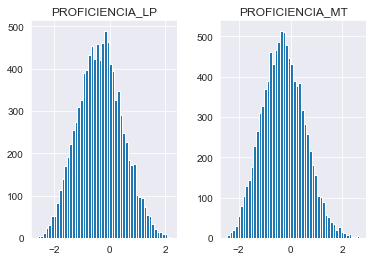

In [259]:
ano9_base[[target_lp, target_mt]].hist(bins=50)
plt.show()

# Amostragem

In [260]:
test_set = ano9_base.loc[np.random.choice(ano9_base.index, 3000, replace=False)].copy()
train_msk = ~ano9_base.index.isin(test_set.index)
train_set = ano9_base.loc[ano9_base.index[train_msk]].copy()

In [261]:
test_set.shape

(3000, 520)

In [262]:
train_set.shape

(7000, 520)

# Avaliação

In [263]:
from sklearn.utils import all_estimators
from sklearn.datasets import load_wine

### Configurando Modelos em "Default"

In [264]:
models_dict = dict(all_estimators('regressor'))
all_models, all_names = list(models_dict.values()), list(models_dict.keys())

y = load_wine()['target']
x = load_wine()['data']

out_models = ['GaussianProcessRegressor', 'RANSACRegressor', 'RadiusNeighborsRegressor', 'TheilSenRegressor', 'PoissonRegressor']
default={}
models={}
error = []

cnt = 0
n_iter = len(all_names)
for name, model in zip(all_names, all_models):
    try:
        if name not in out_models:
            default[name] = model().fit(x, y).get_params()
            models[name] = model
    except:
        error.append(name)
    cnt+=1
    clear_output(wait=True)
    print(cnt, '/', n_iter)

names = list(models.keys())
models_list = list(models.values())
params_list = list(default.values())

54 / 54


In [265]:
len(models), len(names), len(params_list)

(39, 39, 39)

In [267]:
scrs = scr_regs(train_set, test_set, target_lp, models, params_list, stop=None)

Scoring TweedieRegressor - (39/39)

Fitting...
Predicting...
Scoring...


C:\Users\luisr\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


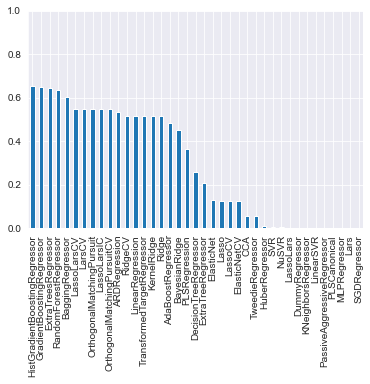

In [268]:
scrs.sort_values(ascending=False).plot.bar(ylim=(0,1))

In [271]:
top_models = scrs.sort_values(ascending=False).head(10).index.tolist()

# 3. Escolha do tamanho da amostra

In [116]:
def multi_sample_index(index, start=0.1, n_points=10, degree=2):
    
    n_indices = len(index)
    ps = np.linspace(start, 1, n_points)**degree
    sizes = [int(i) for i in ps*n_indices]
    
    new_indexes = []
    for size in sizes:
        new_indexes.append(np.random.choice(index, size, replace=False))
        
    return new_indexes

In [178]:
def size_tune_reg(train_set, test_set, target, models, params_list=None, start=0.1, n_points=10, degree=2, concat_to=None):
    
    indexes = multi_sample_index(train_set.index, start, n_points, degree)
    n_ind = len(indexes)
    n_samples = len(indexes[-1])

    size_scrs = []
    cnt=1
    for index in indexes:
        
        sample_size = len(index)
        step_train = train_set.loc[index]
        clear_output(wait=True)
        print('Avaliando Amostra {}/{} Tamanho {}/{}'.format(cnt, n_ind, sample_size, n_samples))
        step_scr = scr_regs(step_train,
                            test_set,
                            target,
                            models,
                            params_list,
                            clear=False)

        step_scr.name = sample_size
        size_scrs.append(step_scr)
        cnt+=1
        
    size_df = pd.concat(size_scrs, axis=1)
    
    if type(concat_to)!=type(None): size_df = pd.concat([concat_to, size_df])
    
    return size_df

In [130]:
len(np.unique(list(models.keys()))), len(models)

(44, 44)

In [ ]:
size_opt = size_tune_reg(train_set, test_set, target_lp, {name:models[name] for name in names[:7]})

### Salvando Otimização

In [98]:
size_opt_path =

In [176]:
#size_opt.to_csv(size_opt_path.format(''))

### Imprimindo Resultado

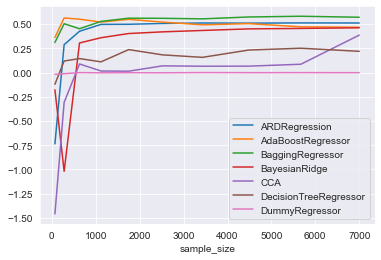

In [179]:
size_opt.T.plot(x='sample_size')

# Reamostragem

In [213]:
train_msk = ~ano9_base.index.isin(test_set.index)
train_set = ano9_base.loc[np.random.choice(ano9_base.index[train_msk], 1500, replace=False)].copy()

In [218]:
print(test_set.shape)
print(train_set.shape)

(3000, 520)
(1500, 520)


### Configurando Modelos que possuem o atributo "coef_" ou "feature_importances_"

In [228]:
features = [ col for col in train_set if col!=target_lp]

In [225]:
y = train_set[target_lp]
x = train_set[features]

out_models = ['GaussianProcessRegressor', 'RANSACRegressor', 'RadiusNeighborsRegressor', 'TheilSenRegressor', 'PoissonRegressor']

coef_params={}
coef_models={}

not_coef = []

cnt = 0
n_iter = len(all_names)
for name, model in zip(all_names, all_models):
    try:
        if name not in out_models:
            teste = model().fit(x, y).coef_           
            coef_params[name] = model().get_params()
            coef_models[name] = model
    except:
        try:
            if name not in out_models:
                teste = model().fit(x, y).feature_importances_
                coef_params[name] = model().get_params()
                coef_models[name] = model

        except:        
            not_coef.append(name)

    cnt+=1
    clear_output(wait=True)
    print(cnt, '/', n_iter)

coef_names, coef_models, coef_params = list(coef_models.keys()), list(coef_models.values()), list(coef_params.values())

54 / 54


In [226]:
len(coef_names), len(coef_models), len(coef_params)

(30, 30, 30)

# Calculando Ranks

In [210]:
from sklearn.feature_selection import RFE

In [ ]:
ranks_df = RFE_ranks(coef_models[:], coef_names[:], coef_params[:], train_set, target_lp, 20, 20, 1, save=False, path=None)

In [232]:
ranks_df.to_csv('Análise Simples/Ranks - Proficiência lp.csv')

# Avaliando Ranks

In [364]:
good_models = {name:models[name] for name in top_models}

In [363]:
main_ranks = [ranks_df[col].unique() for col in ranks_df][0]

In [368]:
main_ranks

array([26, 25, 24, 23,  5,  9,  3,  8,  1,  7,  2, 10,  6, 11,  4, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22])

In [374]:
ranks_scrs = rec_ranks_df[['rank model']+[col for col in main_ranks if col in rec_ranks_df.columns]]

In [ ]:
rec_ranks_df = ranks_recursive_scoring_reg(ranks_df[coef_names], small_train_set, test_set, target_lp,
                                       good_models, None,
                                       rank_degree=2, n_first=8)

In [408]:
rec_ranks_df.to_csv('Análise Simples/Avaliação Ranks Proficiência LP.csv')

#### Colunas para avaliação

In [278]:
scrs_cols=[]
cols = rec_ranks_df.columns.tolist()

for a, b in [[0,1], [2,4], [5,7], [8,13]]:
    scrs_cols.append(cols[a:b+1])

### Imprimindo Resultado

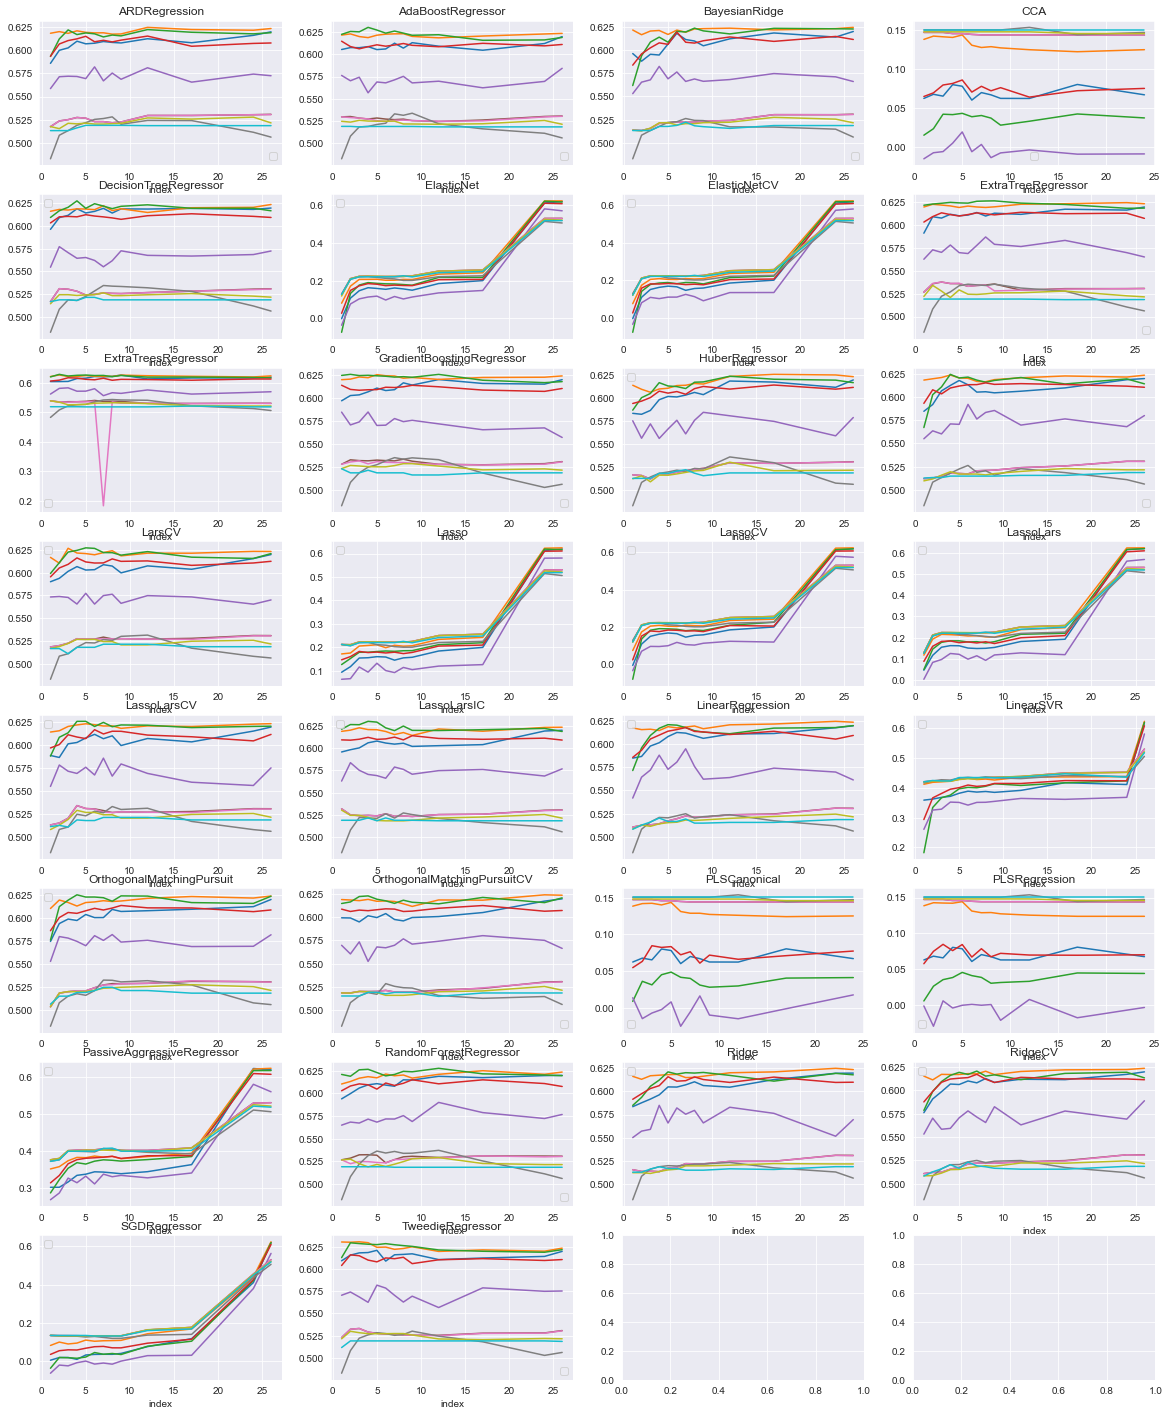

In [399]:
ranks = ranks_scrs['rank model'].unique()
n_ranks = len(ranks)

fig, axs = plt.subplots(int(n_ranks/4)+1, 4, figsize=(20,25))

row_cnt = 0
col_cnt = 0
for rank in ranks:
    
    if col_cnt==4:
        col_cnt=0
        row_cnt+=1
        
    ranks_scrs[ranks_scrs['rank model']==rank].T.drop('rank model').reset_index().sort_values('index').plot(x='index', ax=axs[row_cnt][col_cnt])
    axs[row_cnt][col_cnt].legend([])
    axs[row_cnt][col_cnt].set_title(rank)
    
    col_cnt+=1
plt.show()

In [404]:
ranks_scrs.drop('rank model', 1)[ranks_scrs>0.626]

,26.0,24.0,5.0,9.0,3.0,8.0,1.0,7.0,2.0,6.0,4.0,12.0,17.0
HistGradientBoostingRegressor,0.619801,0.615992,0.606844,0.607788,0.602461,0.608352,0.585779,0.609332,0.599861,0.607511,0.609682,0.612329,0.608025
GradientBoostingRegressor,0.623365,0.621540,0.619228,0.617512,0.618155,0.617295,0.618254,0.618748,0.620019,0.618646,0.620870,0.624603,0.622256
ExtraTreesRegressor,0.618838,0.617604,0.618607,0.615413,0.621861,0.616324,0.593222,0.614298,0.612133,0.617623,0.616843,0.622224,0.619325
RandomForestRegressor,0.607760,0.607290,0.614962,0.610834,0.610353,0.608923,0.593397,0.610662,0.606673,0.609073,0.612215,0.615205,0.604227
BaggingRegressor,0.572418,0.574187,0.569314,0.568591,0.571898,0.575312,0.558539,0.566876,0.571357,0.581976,0.571612,0.581015,0.565507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LassoLarsCV,0.530770,0.528094,0.527606,0.525520,0.533091,0.525913,0.522874,0.526906,0.532249,0.526812,0.529065,0.525436,0.527794
LarsCV,0.530453,0.527834,0.527606,0.525520,0.533091,0.525913,0.522874,0.526906,0.532249,0.526812,0.529065,0.525027,0.527554
OrthogonalMatchingPursuit,0.506174,0.502841,0.528369,0.530093,0.522195,0.526322,0.482780,0.525392,0.508189,0.527350,0.525920,0.524498,0.518104
LassoLarsIC,0.521511,0.521844,0.527258,0.525776,0.528360,0.527396,0.521530,0.527396,0.529957,0.527258,0.527258,0.521339,0.520521


In [381]:
scrs_prog_pages(ranks_scrs, top_models, cols=[[]])

TypeError: scrs_prog_pages() missing 1 required positional argument: 'cols'

# Selecionando top X Colunas e Ranks para Segunda Análise

In [41]:
def union(df, n_top=1319, rank=True):
    union_lst = []
    for i, col in enumerate(df):
        
        if rank:
            union_lst += df[col].sort_values()[df[col].sort_values()<=n_top].index.tolist()           
        else:
            union_lst += df[col].sort_values().index.tolist()[:n_top]
    union_lst = list(set(union_lst))
    return union_lst

In [42]:
keep_ranks = ['ExtraTreesClassifier', 'GradientBoostingClassifier']
keep_df = ranks_df[keep_ranks]

In [43]:
top_features = union(keep_df, n_top=3)

In [44]:
len(top_features)

2331